In [1]:
import requests
import math as m
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import geopandas as gpd
import matplotlib as mpl
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.integrate import solve_ivp
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
sns.set_style('darkgrid')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Building the RMBH network

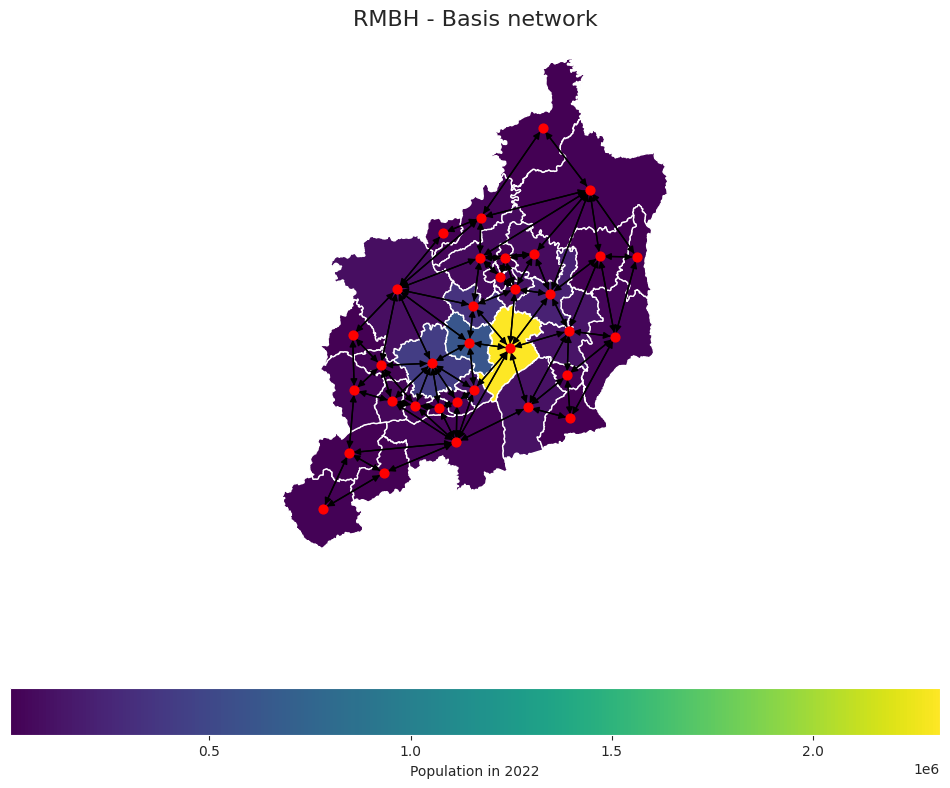

In [3]:
# Fazendo a requisição para a página
url = "https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_Belo_Horizonte"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrando a seção desejada
secao = soup.find('h3', id='Colar_Metropolitano')
tabela = secao.find_next('table', class_='toccolours')

# Encontrando todas as linhas da tabela, excluindo as primeiras e as últimas
linhas = tabela.find_all('tr')[3:-7]

# Lista para armazenar os dados
dados = []

# Iterando sobre as linhas da tabela e extraindo os dados
for i, linha in enumerate(linhas):
    colunas = linha.find_all('td')
    if len(colunas) >= 4:
      municipio_1 = colunas[1].text.strip()
      populacao_1 = colunas[2].text.strip()
      area_1 = colunas[3].text.strip()
      pib_1 = colunas[4].text.strip()
      dados.append([municipio_1, populacao_1, area_1, pib_1])

    # Verificando se o índice da linha é maior ou igual a 16
    if i >= 16:
        # Verificar se há um segundo município na mesma linha
        if len(colunas) > 5:
            municipio_2 = colunas[7].text.strip()
            populacao_2 = colunas[8].text.strip()
            area_2 = colunas[9].text.strip()
            pib_2 = colunas[10].text.strip()
            dados.append([municipio_2, populacao_2, area_2, pib_2])

# Criando o DataFrame
BH_census = pd.DataFrame(dados, columns=['munic_nome', 'populacao', 'area_km2', 'PIB'])

BH_census['populacao'] = BH_census['populacao'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
BH_census['area_km2'] = BH_census['area_km2'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
BH_census['PIB'] = BH_census['PIB'].apply(lambda x: float(x.replace('.', '').replace(',', '.')) * 1_000_000)
BH_census = BH_census.sort_values(by='munic_nome')

# Verificando se o nome do município contém um asterisco ('*') no final
mask = BH_census['munic_nome'].str.contains('\*$')

# Removendo as linhas que correspondem à condição
BH_census = BH_census[~mask]
BH_census.reset_index(drop=True, inplace=True)
BH_census['munic_nome'] = BH_census['munic_nome'].apply(lambda x: x.upper())

# Carregar o shapefile em um GeoDataFrame
gdf = gpd.read_file('/content/drive/MyDrive/data_IC/BH_data/RMBH_raw_data/Mun_RMBH.shp')
gdf = gdf.sort_values(by='NM_MUNICIP').reset_index(drop=True)
gdf['POPULATION'] = BH_census['populacao']
gdf['AREA'] = BH_census['area_km2']
gdf['GDP'] = BH_census['PIB']
gdf['centroid'] = gdf['geometry'].centroid

# Criar o dígrafo
BH_basis_net = nx.DiGraph()

# Adicionar nós com atributos
for idx, row in gdf.iterrows():
    node_id = row['ID']
    node_data = {
        'CD_GEOCODM': row['CD_GEOCODM'],
        'NM_MUNICIP': row['NM_MUNICIP'],
        'POPULATION': row['POPULATION'],
        'AREA': row['AREA'],
        'GDP': row['GDP'],
        'xcoord': row['centroid'].x,
        'ycoord': row['centroid'].y
    }
    BH_basis_net.add_node(node_id, **node_data)

# Adicionar arestas entre municípios vizinhos ou que se cruzam
for index, row in gdf.iterrows():
    node_id = row['ID']
    connected_nodes = []

    # Verificar se é o nó com ID '995' ou '1085' para adicionar conexões
    if node_id == 995:
        connected_nodes.append(1085)
    elif node_id == 1085:
        connected_nodes.append(995)

    # Verificar se o município é vizinho ou se se cruzam
    for other_index, other_row in gdf.iterrows():
        if node_id != other_row['ID'] and row['geometry'].intersects(other_row['geometry']):
            connected_nodes.append(other_row['ID'])

    # Adicionar arestas
    for connected_node in connected_nodes:
        BH_basis_net.add_edge(node_id, connected_node)

gdf.plot(
    figsize=(12, 10),
    column='POPULATION',
    legend=True,
    cmap='viridis',
    legend_kwds={"label": "Population in 2022", "orientation": "horizontal"},
)

names = [v for _, v in nx.get_node_attributes(BH_basis_net, 'NM_MUNICIP').items()]

# Plotar o grafo (opcional)
pos = {node: (data['xcoord'], data['ycoord']) for node, data in BH_basis_net.nodes(data=True)}
nx.draw(BH_basis_net, pos, node_size=40, node_color='red', edge_color='black')
plt.title('RMBH - Basis network', fontsize=16)
plt.show()

Há alguns problemas em aberto:

* **1)** Geração sintética de fluxos: a partir de um grafo de entrada e as respectivas populações dos nós, gerar fluxos sintéticos entre os nós. Vc já tem isso funcionando para o caso all-to-all, mas o ideal seria ter um grafo como base, pois por ele a gente consegue inclusive os resultados do caso all-to-all se o grafo for completo; (acho que se você chegar até aqui nesta IC, já tá bom demais). Aí a gente roda algumas simulações com o modelo e faz análises dos resultados.

* **2)** A partir de uma matriz de fluxos real (grafo), com dados reais, converter seus pesos para taxas, respeitando a restrição de conservar as populações iguais durante toda a simulação. Essa matriz pode conter taxas nas suas arestas, como no dado da China. Possível solução: poderíamos utilizar as taxas reais entre os nós ao invés de sortearmos os fluxos entre os vizinhos, como estamos fazendo atualmente. Não sei se isso por si só garante populações constantes. Podemos tentar.  

* **3)** Será que a gente conseguiria atribuir números de viajantes que entram e saem das cidades, ao invés de apenas uma porcentagem que vai balizar toda a movimentação a partir da cidade de menor população? Na prática, as pessoas se movimentam mais ou menos a depender das cidades e se esse número for conhecido, as taxas de fluxos deveriam ser computadas a partir deles.

# 1st heuristic - Without receving a net topology (all-to-all)


In [4]:
np.random.seed(1)

# Criar a rede BH_basis_net como um digrafo (grafo direcionado) com 4 nós
# O grafo direcionado permite que as arestas tenham uma direção, representando o fluxo de um nó para outro
#BH_basis_net = nx.DiGraph()
#nodes = [i for i in range(4)]  # Criação de uma lista de nós, numerados de 0 a 3
#BH_basis_net.add_nodes_from(nodes)  # Adiciona os nós à rede

# Adicionar alguns atributos de exemplo para os nós
# Cada nó na rede representa um município, então aqui nomeamos os nós como 'Município 1', 'Município 2', etc.
#for node in nodes:
#    BH_basis_net.nodes[node]['NM_MUNICIP'] = f'Município {node + 1}'

# Obter os nomes dos municípios formatados
# Formata os nomes dos municípios para que a primeira letra de cada parte seja maiúscula,
# exceto por palavras específicas ('de', 'da', 'das'), que permanecem em minúsculas
names = []
for _, v in nx.get_node_attributes(BH_basis_net, 'NM_MUNICIP').items():
    parts = v.split()  # Dividir o nome em partes (ex.: 'Município 1' vira ['Município', '1'])
    # Formatar as partes do nome
    capitalized_parts = [parts[0].capitalize()] + [part.lower() if part.lower() in ['de', 'da', 'das'] else part.capitalize() for part in parts[1:]]
    capitalized_name = ' '.join(capitalized_parts)  # Reunir as partes formatadas em uma string
    names.append(capitalized_name)  # Adicionar o nome formatado à lista de nomes

# ------------------ GERAÇÃO DAS MATRIZES ------------------

# Número de nós, ou seja, o número de municípios
N = len(names)

# Definição de algumas opções para populações iniciais em cada nó
# Neste caso, estamos utilizando uma população inicial fixa para cada nó
#N0 = np.array([50, 20, 100, 1000])  # População inicial em cada nó
#N0 = np.array([50, 55, 60, 65])  # População inicial em cada nó
#N0 = np.random.randint(0, 1001, size=34)  # Exemplo de geração de populações aleatórias
N0 = np.array([v for _, v in nx.get_node_attributes(BH_basis_net, 'POPULATION').items()])  # Extração de populações dos atributos da rede BH_basis_net

# Taxa de movimentação, ou seja, a fração da população que se movimenta diariamente entre os nós
per_movers = 0.1

# Função para gerar fluxos aleatórios baseados na distribuição de Dirichlet
def get_random_flows(rate_of_movers, populations):
    # Gera uma distribuição de fluxos que somam 1 e multiplica pela taxa de movimentação
    return np.random.dirichlet(np.ones(len(populations))) * rate_of_movers

# Função para calcular a capacidade restante de movimentação em um nó específico
def get_remaining_capacity(data, rate_of_movers, pop_buffer, current_idx):
    # Retorna a diferença entre o total possível de movimentos e o que já foi alocado
    return data[current_idx] * rate_of_movers - pop_buffer[current_idx]

# Função para gerar tensores de fluxos temporais
def generate_temporal_flow_tensors(data, num_days, rate_of_movers, G):
    N = len(data)  # Número de nós
    data_index = np.argsort(data)  # Ordena os nós de acordo com suas populações

    # Inicializa os tensores de fluxos de entrada e saída para os dias simulados
    in_flows = np.zeros((num_days, N, N))
    out_flows = np.zeros((num_days, N, N))

    # Itera sobre os dias para simular os fluxos diários
    for day in range(num_days):
        # Gera fluxos base para o dia
        base_flows = get_random_flows(rate_of_movers, data)

        # Buffers para acumular os fluxos recebidos e enviados
        pop_buffer_in = np.zeros(N)
        pop_buffer_out = np.zeros(N)

        # Itera sobre os nós, excluindo o nó com a maior população, para processar os fluxos
        for i, ind_src in enumerate(data_index[:N-1]):
            initial_population = data[ind_src]  # População inicial do nó fonte
            current_population = data[ind_src]  # População atual do nó fonte

            # Calcula a capacidade restante de entrada e saída
            remaining_capacity_in = get_remaining_capacity(data, rate_of_movers, pop_buffer_in, ind_src)
            remaining_capacity_out = get_remaining_capacity(data, rate_of_movers, pop_buffer_out, ind_src)

            # Calcula as taxas de capacidade
            rc_rate_in = remaining_capacity_in / current_population
            rc_rate_out = remaining_capacity_out / current_population

            # Ajusta as taxas reais de movimentação para não ultrapassar a capacidade restante
            rom_in = np.min([rc_rate_in, rate_of_movers])
            rom_out = np.min([rc_rate_out, rate_of_movers])

            # Calcula os fluxos ajustados com base nos fluxos aleatórios gerados
            rates_in = base_flows * rom_in
            rates_out = base_flows * rom_out

            idx = 0  # Índice para iterar sobre os nós de destino
            for ind_tgt in data_index[i:N]:
                # Calcula os fluxos recebidos e enviados
                received = rates_in[idx] * current_population
                sent = rates_out[idx] * current_population

                # Atualiza os tensores de fluxos de entrada e saída
                in_flows[day, ind_tgt, ind_src] = received / data[ind_tgt]
                out_flows[day, ind_src, ind_tgt] = sent / data[ind_tgt]

                # Atualiza os buffers de entrada e saída
                pop_buffer_in[ind_src] += received
                pop_buffer_out[ind_tgt] += received
                pop_buffer_out[ind_src] += sent
                pop_buffer_in[ind_tgt] += sent

                # Print para acompanhar o fluxo de indivíduos entre os nós
                print(f'Sending {sent} hosts to {ind_tgt}')
                print(f'Receiving {received} hosts from {ind_tgt}\n')

                idx += 1  # Incrementa o índice para o próximo nó de destino

    # Retorna os tensores de fluxos de entrada e saída para todos os dias
    return in_flows, out_flows

# Define o número de dias para a simulação
num_days = 45

# Executa a função para gerar os tensores de fluxos
inflow, outflow = generate_temporal_flow_tensors(N0, num_days, per_movers, BH_basis_net)

# Função para verificar se o que entra é igual ao que sai em cada nó
def get_what_leaves_is_the_same_as_what_comes(populations, inflow, outflow):
    N = len(populations)  # Número de nós
    they_are_the_same = True  # Variável para verificar a consistência
    for day in range(inflow.shape[0]):  # Itera sobre os dias
        for i in range(N):  # Itera sobre os nós
            total_in = np.sum(inflow[day, :, i]) * populations[i]  # Soma dos fluxos de entrada
            total_out = np.sum(outflow[day, i, :]) * populations[i]  # Soma dos fluxos de saída
            # Verifica se há discrepância entre o que entra e o que sai
            if np.abs(total_in - total_out) > 0.00001:
                they_are_the_same = False
                break
    return they_are_the_same  # Retorna True se os fluxos são consistentes, False caso contrário

# Executa a função para verificar a consistência dos fluxos
test = get_what_leaves_is_the_same_as_what_comes(
    populations=N0,
    inflow=inflow,
    outflow=outflow
)

# Print para informar se os fluxos são consistentes ou se há discrepâncias
print(f'Everything works fine!' if test else f'Too bad! There are some discrepancies')

A saída de streaming foi truncada nas últimas 5000 linhas.

Sending 4.421933753935393 hosts to 3
Receiving 4.421933753935393 hosts from 3

Sending 2.0871232289384 hosts to 11
Receiving 2.0871232289384 hosts from 11

Sending 0.49381039760796797 hosts to 22
Receiving 0.49381039760796797 hosts from 22

Sending 0.8837747637790516 hosts to 16
Receiving 0.8837747637790516 hosts from 16

Sending 0.36381943142793594 hosts to 8
Receiving 0.36381943142793594 hosts from 8

Sending 1.2268403197838456 hosts to 20
Receiving 1.2268403197838456 hosts from 20

Sending 0.18267157776141132 hosts to 33
Receiving 0.18267157776141132 hosts from 33

Sending 0.3772825098566435 hosts to 27
Receiving 0.3772825098566435 hosts from 27

Sending 0.45858296481750976 hosts to 10
Receiving 0.45858296481750976 hosts from 10

Sending 2.4521685522476795 hosts to 28
Receiving 2.4521685522476795 hosts from 28

Sending 1.780617783643548 hosts to 24
Receiving 1.780617783643548 hosts from 24

Sending 4.313710891920749 hosts t

## Check the total inflow and outflow difference for every node

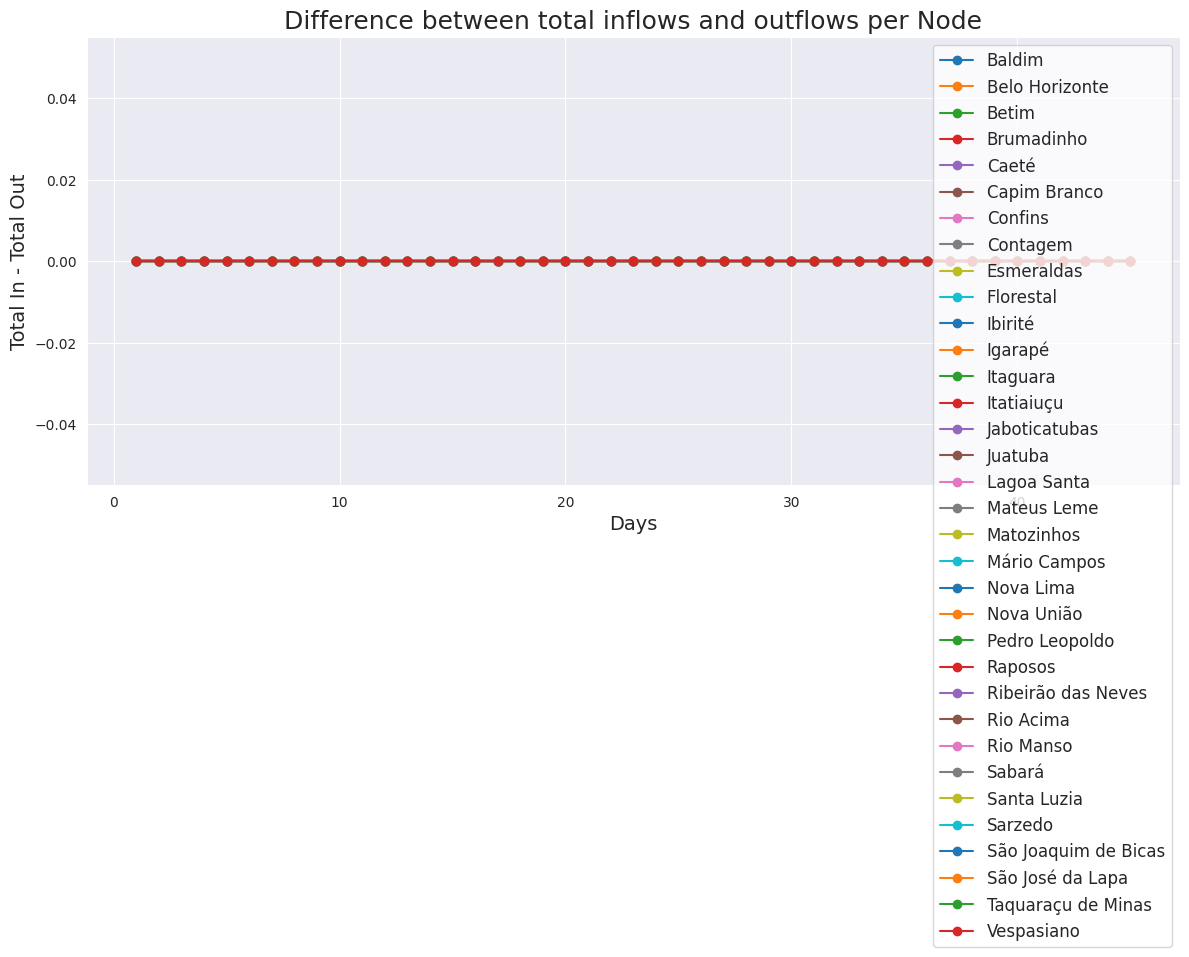

In [5]:
def plot_total_in_minus_out(in_flows, out_flows, populations, node_names):
    num_days = in_flows.shape[0]
    num_nodes = in_flows.shape[1]

    # Inicializa array para armazenar a diferença entre total_in e total_out
    total_in_minus_out = np.zeros((num_days, num_nodes))

    for day in range(num_days):
        for node in range(num_nodes):
            # Calcula o total de entradas e saídas para cada nó
            total_in = np.sum(in_flows[day, node, :]) * populations[node]
            total_out = np.sum(out_flows[day, :, node]) * populations[node]
            # Armazena a diferença
            total_in_minus_out[day, node] = total_in - total_out

    # Plotando a diferença entre total_in e total_out para cada nó ao longo dos dias
    fig, ax = plt.subplots(figsize=(12, 8))
    for node in range(num_nodes):
        ax.plot(range(1, num_days + 1), total_in_minus_out[:, node], marker='o', label=node_names[node])

    ax.set_xlabel('Days', fontsize=14)
    ax.set_ylabel('Total In - Total Out', fontsize=14)
    ax.set_title('Difference between total inflows and outflows per Node', fontsize=18)
    ax.legend(loc='upper right', facecolor='white', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Exemplo de uso:
plot_total_in_minus_out(inflow, outflow, N0, names)

# Models integration

## Eulerian flux model

In [6]:
class FluxModel:
    def __init__(self, N, inflow_matrices, outflow_matrices):
        """
        Inicializa o modelo de fluxo.

        Parâmetros:
        N : array_like
            Vetor inicial de populações em cada nó.
        inflow_matrices : list of numpy.ndarray
            Lista de matrizes NxN das taxas de entrada para cada dia.
        outflow_matrices : list of numpy.ndarray
            Lista de matrizes NxN das taxas de saída para cada dia.
        """
        self.N = N
        self.inflow_matrices = inflow_matrices
        self.outflow_matrices = outflow_matrices
        self.days = len(inflow_matrices)
        self.last_day = float(self.days)

    def omega(self, t, N):
        """
        Calcula a taxa de mudança de hospedeiros nas subpopulações baseada nas matrizes de fluxo,
        operador de transporte Ω

        Parâmetros:
        t : float
            Tempo atual (em dias).
        N : array_like
            Vetor atual de populações em cada nó.

        Retorna:
        dNdt : array_like
            Taxa de mudança de N.
        """
        day = m.floor(t)  # Ajuste para arredondar o tempo para o dia mais próximo
        if t == self.last_day:
            day = int(self.last_day - 1.)
        print('CURRENT TIME POINT: ', t, '- CALCULATED DAY: ', day)  # Debug para verificar o tempo e o dia calculado
        inflow_matrix = self.inflow_matrices[day]
        outflow_matrix = self.outflow_matrices[day]

        dN_dt = np.zeros_like(N)

        for i in range(len(N)):
            incoming = np.sum(inflow_matrix[i, :] * N)
            outgoing = np.sum(outflow_matrix[:, i] * N)
            dN_dt[i] = incoming - outgoing

        return dN_dt

    def solve(self, t_span, N0, num_points=25000, method='RK45'):
        """
        Resolve o sistema de equações diferenciais com um número fixo de pontos de integração.

        Parâmetros:
        t_span : tuple
            Intervalo de tempo para a integração (t0, tf).
        N0 : array_like
            Vetor inicial de populações em cada nó.
        num_points : int, optional
            Número de pontos de integração ao longo do intervalo de tempo (padrão é 25000).
        method : str, optional
            Método de integração a ser usado por solve_ivp (padrão é 'RK45').

        Retorna:
        result : OdeResult
            Objeto com a solução.
        """
        t_eval = np.linspace(t_span[0], t_span[1], num_points)
        sol = solve_ivp(self.omega, t_span, N0, method=method, t_eval=t_eval, dense_output=True)
        return sol

    def check_constraint(self, solution):
        if np.allclose(np.sum(solution.y, axis=0), np.sum(self.N)):
          print('Constraint satisfied!')
        else:
          print('Constraint not satisfied!')

CURRENT TIME POINT:  0.0 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  2e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  3e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  8e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  8.888888888888888e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  3e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  4e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  9e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.888888888888889e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  1.1e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  1.1e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  3.0999999999999995e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  4.0999999999999994e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.099999999999999e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.988888888888888e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.0001109999999

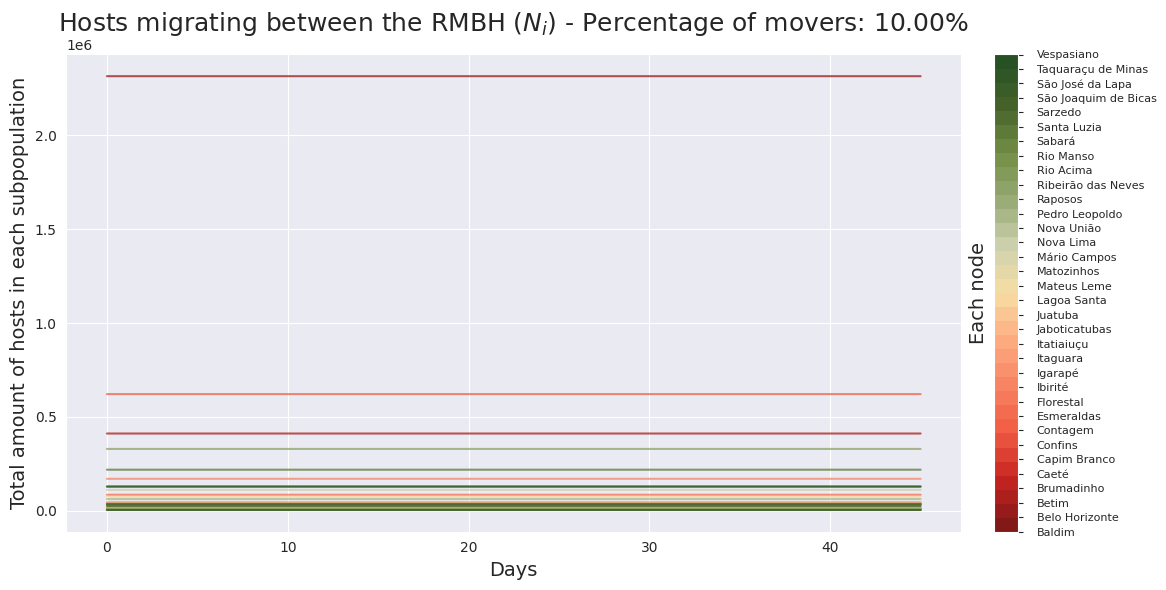

INTEGRATION STEPS:
[0.00100002 0.00100002 0.00100002 ... 0.00100002 0.00100002 0.00100002]


In [7]:
cmap = ['#831818FF', '#C62320FF', '#F05B43FF', '#F78462FF', '#FEAC81FF', '#F7DEA3FF', '#CED1AFFF', '#98AB76FF', '#748F46FF', '#47632AFF', '#275024FF']
cmap = LinearSegmentedColormap.from_list('paquin', cmap[:], N=np.shape(inflow)[1])

t_span = (0, 45)  # Intervalo de tempo de 45 dias
#t_span =(0, 5)

flux_model = FluxModel(N0, inflow, outflow)
solution = flux_model.solve(t_span, N0, num_points=45000)
#solution = flux_model.solve(t_span, N0, num_points=5000)

t = solution.t
N_t = solution.y

# Criação da figura e do eixo (axes)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

for i in range(np.shape(inflow)[1]):
    ax.plot(t, N_t[i], color=cmap(i), alpha=.75)

ax.set_xlabel('Days', fontsize=14)
ax.set_ylabel('Total amount of hosts in each subpopulation', fontsize=14)
ax.set_title(r'Hosts migrating between the RMBH ($N_{i}$)' + f' - Percentage of movers: {per_movers * 100:.2f}%', fontsize=18)

# Adicionando a barra de cores à direita
norm = mpl.colors.Normalize(vmin=1, vmax=np.shape(inflow)[1])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ticks = np.arange(1, np.shape(inflow)[1] + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar = plt.colorbar(sm, orientation='vertical', ax=ax, ticks=ticks, pad=0.03)
cbar.set_label('Each node', fontsize=14)
cbar.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar azul
cbar.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/data_IC/BH_data/output/models_integration/RMBH_flux_model_{per_movers * 100:.2f}%_movers.pdf')
#plt.savefig(f'/content/drive/MyDrive/data_IC/BH_data/output/models_integration/rede_pequena_{"10%"}_movers.pdf')
plt.show()

# Verificando os passos de integração
print("INTEGRATION STEPS:")
print(np.diff(solution.t))

In [8]:
pd.DataFrame(N_t.T, columns=names)

,Baldim,Belo Horizonte,Betim,Brumadinho,Caeté,Capim Branco,Confins,Contagem,Esmeraldas,Florestal,...,Ribeirão das Neves,Rio Acima,Rio Manso,Sabará,Santa Luzia,Sarzedo,São Joaquim de Bicas,São José da Lapa,Taquaraçu de Minas,Vespasiano
0,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0
1,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0
2,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0
3,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0
4,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0
44996,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0
44997,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0
44998,7492.0,2315560.0,411846.0,38915.0,38776.0,10663.0,7350.0,621863.0,85598.0,8045.0,...,329794.0,10261.0,5568.0,129380.0,219132.0,36844.0,34348.0,26090.0,4224.0,129246.0


In [9]:
flux_model.check_constraint(solution)

Constraint satisfied!


## SIR Eulerian model

In [10]:
class SIRFluxModel:
    def __init__(self, S0, I0, R0, inflow_matrices, outflow_matrices, beta, gamma):
        """
        Inicializa o modelo SIR com fluxo.

        Parâmetros:
        S0 : array_like
            Vetor inicial de suscetíveis em cada nó.
        I0 : array_like
            Vetor inicial de infectados em cada nó.
        R0 : array_like
            Vetor inicial de recuperados em cada nó.
        inflow_matrices : list of numpy.ndarray
            Lista de matrizes NxN das taxas de entrada para cada dia.
        outflow_matrices : list of numpy.ndarray
            Lista de matrizes NxN das taxas de saída para cada dia.
        beta : array_like
            Taxa de transmissão em cada nó.
        gamma : float
            Taxa de recuperação (assumida constante para todos os nós).
        """
        self.S0 = S0
        self.I0 = I0
        self.R0 = R0
        self.inflow_matrices = inflow_matrices
        self.outflow_matrices = outflow_matrices
        self.beta = beta
        self.gamma = gamma
        self.N = S0 + I0 + R0
        self.days = len(inflow_matrices)
        self.last_day = float(self.days)

    def sir_flux(self, t, y):
        """
        Equações diferenciais do modelo SIR com fluxo.

        Parâmetros:
        t : float
            Tempo atual (em dias).
        y : array_like
            Vetor atual de [S, I, R] em cada nó.

        Retorna:
        dydt : array_like
            Taxa de mudança de [S, I, R].
        """
        S, I, R = np.split(y, 3)
        day = int(np.floor(t))
        if t == self.last_day:
            day = int(self.last_day - 1)
        print('CURRENT TIME POINT: ', t, '- CALCULATED DAY: ', day)  # Debug para verificar o tempo e o dia calculado
        inflow_matrix = self.inflow_matrices[day]
        outflow_matrix = self.outflow_matrices[day]

        dS_dt = -self.beta * S * I / self.N
        dI_dt = self.beta * S * I / self.N - self.gamma * I
        dR_dt = self.gamma * I

        dS_flux = np.zeros_like(S)
        dI_flux = np.zeros_like(I)
        dR_flux = np.zeros_like(R)

        for i in range(len(S)):
            incoming_S = np.sum(inflow_matrix[i, :] * S)
            outgoing_S = np.sum(outflow_matrix[:, i] * S[i])
            dS_flux[i] = incoming_S - outgoing_S

            incoming_I = np.sum(inflow_matrix[i, :] * I)
            outgoing_I = np.sum(outflow_matrix[:, i] * I[i])
            dI_flux[i] = incoming_I - outgoing_I

            incoming_R = np.sum(inflow_matrix[i, :] * R)
            outgoing_R = np.sum(outflow_matrix[:, i] * R[i])
            dR_flux[i] = incoming_R - outgoing_R

        dS_dt += dS_flux
        dI_dt += dI_flux
        dR_dt += dR_flux

        return np.concatenate([dS_dt, dI_dt, dR_dt])

    def solve(self, t_span, num_points=25000, method='RK45'):
        """
        Resolve o sistema de equações diferenciais com um número fixo de pontos de integração.

        Parâmetros:
        t_span : tuple
            Intervalo de tempo para a integração (t0, tf).
        num_points : int, optional
            Número de pontos de integração ao longo do intervalo de tempo (padrão é 25000).
        method : str, optional
            Método de integração a ser usado por solve_ivp (padrão é 'RK45').

        Retorna:
        result : OdeResult
            Objeto com a solução.
        """
        y0 = np.concatenate([self.S0, self.I0, self.R0])
        t_eval = np.linspace(t_span[0], t_span[1], num_points)
        sol = solve_ivp(self.sir_flux, t_span, y0, method=method, t_eval=t_eval, dense_output=True)
        return sol

    def check_constraint(self, solution):
        """
        Verifica se a população total (N_i = S_i + I_i + R_i) é preservada ao longo do tempo.

        Parâmetros:
        solution : OdeResult
            Objeto com a solução obtida pelo método solve.

        Retorna:
        bool
            True se a condição é satisfeita, False caso contrário.
        """
        S_t = solution.y[:len(self.N), :]
        I_t = solution.y[len(self.N):2*len(self.N), :]
        R_t = solution.y[2*len(self.N):, :]

        N_t = S_t + I_t + R_t

        if np.allclose(np.sum(N_t, axis=0), np.sum(self.N)):
            print('Constraint satisfied!')
        else:
            print('Constraint not satisfied!')

CURRENT TIME POINT:  0.0 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.00014134621661222838 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.002826924332244568 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.004240386498366852 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.011307697328978272 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.012564108143309188 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.014134621661222839 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.014134621661222839 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.042403864983668514 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.056538486644891355 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.12721159495100554 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.13977570309431472 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.15548083827345122 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.15548083827345122 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.3334592579206084 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.4224484677441869 - CALCULATED DAY:  0
CURRENT TIME PO

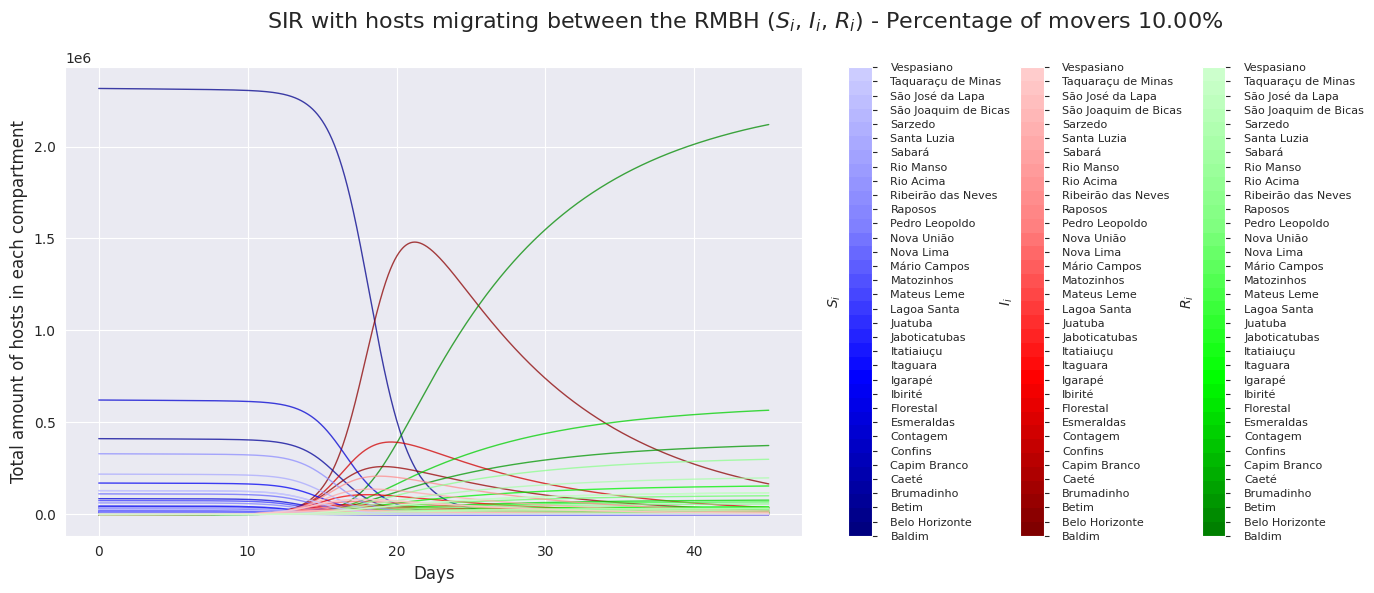

In [11]:
# Definindo os colormaps
blue_colors = [(0, 0, 0.5), (0, 0, 1), (0.5, 0.5, 1), (0.8, 0.8, 1)]  # azul escuro para azul claro
green_colors = [(0, 0.5, 0), (0, 1, 0), (0.5, 1, 0.5), (0.8, 1, 0.8)]  # verde escuro para verde claro
red_colors = [(0.5, 0, 0), (1, 0, 0), (1, 0.5, 0.5), (1, 0.8, 0.8)]  # vermelho escuro para vermelho claro

n_bins = np.shape(inflow)[1]  # número de bins para o colormap

blue_cmap = LinearSegmentedColormap.from_list('dark_to_light_blue', blue_colors, N=n_bins)
green_cmap = LinearSegmentedColormap.from_list('dark_to_light_green', green_colors, N=n_bins)
red_cmap = LinearSegmentedColormap.from_list('dark_to_light_red', red_colors, N=n_bins)

S0 = N0 - 1
#S0 = np.array(data) - 1
I0 = np.array([1] * np.shape(inflow)[1])
R0 = np.array([0] * np.shape(inflow)[1])
#S0 = np.array([499] * np.shape(inflow)[1])  # Vetor inicial de suscetíveis em cada nó
#I0 = np.array([1] * np.shape(inflow)[1])  # Vetor inicial de infectados em cada nó
#R0 = np.array([0] * np.shape(inflow)[1])  # Vetor inicial de recuperados em cada nó
#beta = np.array([0.3] * np.shape(inflow)[1])  # Taxa de transmissão em cada nó
#beta = np.random.uniform(0, 0.95, len(names))
beta = np.array([0.9] * len(names))
#beta = np.random.uniform(0, 0.95, len(data))
gamma = 0.1  # Taxa de recuperação (constante para todos os nós)

sir_flux_model = SIRFluxModel(S0, I0, R0, inflow, outflow, beta, gamma)
t_span = (0, 45)  # Intervalo de tempo de 45 dias
#t_span = (0, 5)

#solution = sir_flux_model.solve(t_span, num_points=50000)
solution = sir_flux_model.solve(t_span, num_points=5000)

t = solution.t
S_t, I_t, R_t = np.split(solution.y, 3)

fig, ax = plt.subplots(figsize=(15, 6))  # Reduzindo o tamanho da figura

for i in range(np.shape(inflow)[1]):
    ax.plot(t, S_t[i], color=blue_cmap(i), lw=1, alpha=0.75)
    ax.plot(t, I_t[i], color=red_cmap(i), lw=1, alpha=0.75)
    ax.plot(t, R_t[i], color=green_cmap(i), lw=1, alpha=0.75)

# Adicionando barras de cores menores à direita com labels centralizados
norm = mpl.colors.Normalize(vmin=1, vmax=np.shape(inflow)[1])

sm_green = ScalarMappable(cmap=green_cmap, norm=norm)
sm_green.set_array([])
ticks_green = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_green = plt.colorbar(sm_green, orientation='vertical', ax=ax, ticks=ticks_green, pad=0.01)
cbar_green.set_label(r'$R_{i}$', fontsize=10)
cbar_green.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_green.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_green.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar verde
cbar_green.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

sm_red = ScalarMappable(cmap=red_cmap, norm=norm)
sm_red.set_array([])
ticks_red = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_red = plt.colorbar(sm_red, orientation='vertical', ax=ax, ticks=ticks_red, pad=0.03)
cbar_red.set_label(r'$I_{i}$', fontsize=10)
cbar_red.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_red.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_red.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar vermelho
cbar_red.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

sm_blue = ScalarMappable(cmap=blue_cmap, norm=norm)
sm_blue.set_array([])
ticks_blue = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_blue = plt.colorbar(sm_blue, orientation='vertical', ax=ax, ticks=ticks_blue, pad=0.05)
cbar_blue.set_label(r'$S_{i}$', fontsize=10)
cbar_blue.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_blue.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_blue.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar azul
cbar_blue.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Total amount of hosts in each compartment', fontsize=12)
fig.suptitle(r'SIR with hosts migrating between the RMBH ($S_i$, $I_i$, $R_i$)' + f' - Percentage of movers {per_movers * 100:.2f}%', fontsize=16)

# Ajustando a posição da legenda
#ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.subplots_adjust(right=0.5)  # Ajustando o espaço à direita das barras de cores
plt.tight_layout()

# Salvando a figura como PDF otimizado
plt.savefig(f'/content/drive/MyDrive/data_IC/BH_data/output/models_integration/RMBH_SIR_model_{per_movers * 100:.2f}%_movers.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

# 2st heuristic - Receving a net topology

A saída de streaming foi truncada nas últimas 5000 linhas.

Dia 35: Enviando 17.100862707460927 de 22 para 14
Dia 35: Recebendo 17.100862707460927 de 14 para 22

Dia 35: Enviando 5.549504856060913 de 22 para 16
Dia 35: Recebendo 5.549504856060913 de 16 para 22

Dia 35: Enviando 9.537455018675171 de 22 para 18
Dia 35: Recebendo 9.537455018675171 de 18 para 22

Dia 35: Enviando 13.640619492489217 de 22 para 24
Dia 35: Recebendo 13.640619492489217 de 24 para 22

Dia 35: Enviando 6.984082550302366 de 22 para 31
Dia 35: Recebendo 6.984082550302366 de 31 para 22

Dia 35: Enviando 30.958109927758223 de 22 para 33
Dia 35: Recebendo 30.958109927758223 de 33 para 22

Dia 35: Enviando 0.386722670133454 de 16 para 6
Dia 35: Recebendo 0.386722670133454 de 6 para 16

Dia 35: Enviando 58.042107022577255 de 16 para 14
Dia 35: Recebendo 58.042107022577255 de 14 para 16

Dia 35: Enviando 20.590424552009818 de 16 para 22
Dia 35: Recebendo 20.590424552009818 de 22 para 16

Dia 35: Enviando 6.6819237715931

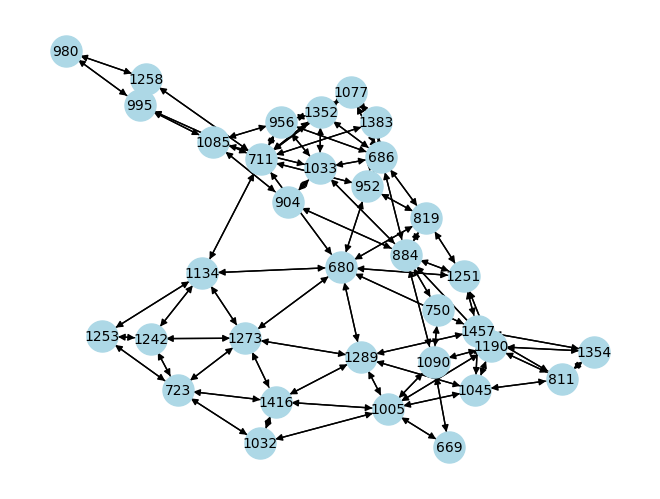

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Exemplo de matriz de adjacência para uma rede com 5 nós
adjacency_matrix = np.array([
    [0, 1, 0, 1, 0],
    [1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0],
    [1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0]
])

# Visualizando a rede
#G = nx.from_numpy_array(adjacency_matrix)

# População inicial para cada nó (aleatória entre 100 e 1000)
#N0 = np.random.randint(100, 1001, size=34)
N0 = np.array([v for _, v in nx.get_node_attributes(BH_basis_net, 'POPULATION').items()])
print("Populações iniciais:", N0)

# Taxa de movimentação (10% da população se move diariamente)
per_movers = 0.1

# Função para gerar fluxos aleatórios baseados na distribuição de Dirichlet
def get_random_flows(rate_of_movers, populations):
    return np.random.dirichlet(np.ones(len(populations))) * rate_of_movers

# Função para calcular a capacidade restante de movimentação em um nó específico
def get_remaining_capacity(data, rate_of_movers, pop_buffer, current_idx):
    return data[current_idx] * rate_of_movers - pop_buffer[current_idx]

# Função para gerar tensores de fluxos temporais
def generate_temporal_flow_tensors(data, num_days, rate_of_movers, G):
    N = len(data)  # Número de nós
    data_index = np.argsort(data)  # Ordena os nós de acordo com suas populações

    # Inicializa os tensores de fluxos de entrada e saída para os dias simulados
    in_flows = np.zeros((num_days, N, N))
    out_flows = np.zeros((num_days, N, N))

    # Itera sobre os dias para simular os fluxos diários
    for day in range(num_days):
        # Gera fluxos base para o dia
        base_flows = get_random_flows(rate_of_movers, data)

        # Buffers para acumular os fluxos recebidos e enviados
        pop_buffer_in = np.zeros(N)
        pop_buffer_out = np.zeros(N)

        # Itera sobre os nós, excluindo o nó com a maior população, para processar os fluxos
        for i, ind_src in enumerate(data_index[:N-1]):
            initial_population = data[ind_src]  # População inicial do nó fonte
            current_population = data[ind_src]  # População atual do nó fonte

            # Calcula a capacidade restante de entrada e saída
            remaining_capacity_in = get_remaining_capacity(data, rate_of_movers, pop_buffer_in, ind_src)
            remaining_capacity_out = get_remaining_capacity(data, rate_of_movers, pop_buffer_out, ind_src)

            # Calcula as taxas de capacidade
            rc_rate_in = remaining_capacity_in / current_population
            rc_rate_out = remaining_capacity_out / current_population

            # Ajusta as taxas reais de movimentação para não ultrapassar a capacidade restante
            rom_in = np.min([rc_rate_in, rate_of_movers])
            rom_out = np.min([rc_rate_out, rate_of_movers])

            # Calcula os fluxos ajustados com base nos fluxos aleatórios gerados
            rates_in = base_flows * rom_in
            rates_out = base_flows * rom_out

            # Obter vizinhos conectados ao nó de origem
            neighbors = np.where(G[ind_src] > 0)[0]

            for idx, ind_tgt in enumerate(neighbors):
                # Calcula os fluxos recebidos e enviados
                received = rates_in[idx] * current_population
                sent = rates_out[idx] * current_population

                # Atualiza os tensores de fluxos de entrada e saída
                in_flows[day, ind_tgt, ind_src] = received / data[ind_tgt]
                out_flows[day, ind_src, ind_tgt] = sent / data[ind_tgt]

                # Atualiza os buffers de entrada e saída
                pop_buffer_in[ind_src] += received
                pop_buffer_out[ind_tgt] += received
                pop_buffer_out[ind_src] += sent
                pop_buffer_in[ind_tgt] += sent

                print(f'Dia {day+1}: Enviando {sent} de {ind_src} para {ind_tgt}')
                print(f'Dia {day+1}: Recebendo {received} de {ind_tgt} para {ind_src}\n')

    # Retorna os tensores de fluxos de entrada e saída para todos os dias
    return in_flows, out_flows

# Define o número de dias para a simulação
num_days = 45

# Executa a função para gerar os tensores de fluxos
inflow, outflow = generate_temporal_flow_tensors(N0, num_days, per_movers, nx.to_numpy_array(BH_basis_net))

# Função para verificar se o que entra é igual ao que sai em cada nó
def get_what_leaves_is_the_same_as_what_comes(populations, inflow, outflow):
    N = len(populations)  # Número de nós
    they_are_the_same = True  # Variável para verificar a consistência
    for day in range(inflow.shape[0]):  # Itera sobre os dias
        for i in range(N):  # Itera sobre os nós
            total_in = np.sum(inflow[day, :, i]) * populations[i]  # Soma dos fluxos de entrada
            total_out = np.sum(outflow[day, i, :]) * populations[i]  # Soma dos fluxos de saída
            # Verifica se há discrepância entre o que entra e o que sai
            if np.abs(total_in - total_out) > 0.00001:
                they_are_the_same = False
                break
    return they_are_the_same  # Retorna True se os fluxos são consistentes, False caso contrário

# Executa a função para verificar a consistência dos fluxos
test = get_what_leaves_is_the_same_as_what_comes(
    populations=N0,
    inflow=inflow,
    outflow=outflow
)

# Print para informar se os fluxos são consistentes ou se há discrepâncias
print(f'Tudo está funcionando corretamente!' if test else f'Há discrepâncias nos fluxos.')

nx.draw(BH_basis_net, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

CURRENT TIME POINT:  0.0 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  2e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  3e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  8e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  8.888888888888888e-07 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  1e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  3e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  4e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  9e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.888888888888889e-06 - CALCULATED DAY:  0
CURRENT TIME POINT:  1.1e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  1.1e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  3.0999999999999995e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  4.0999999999999994e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.099999999999999e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  9.988888888888888e-05 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.0001109999999

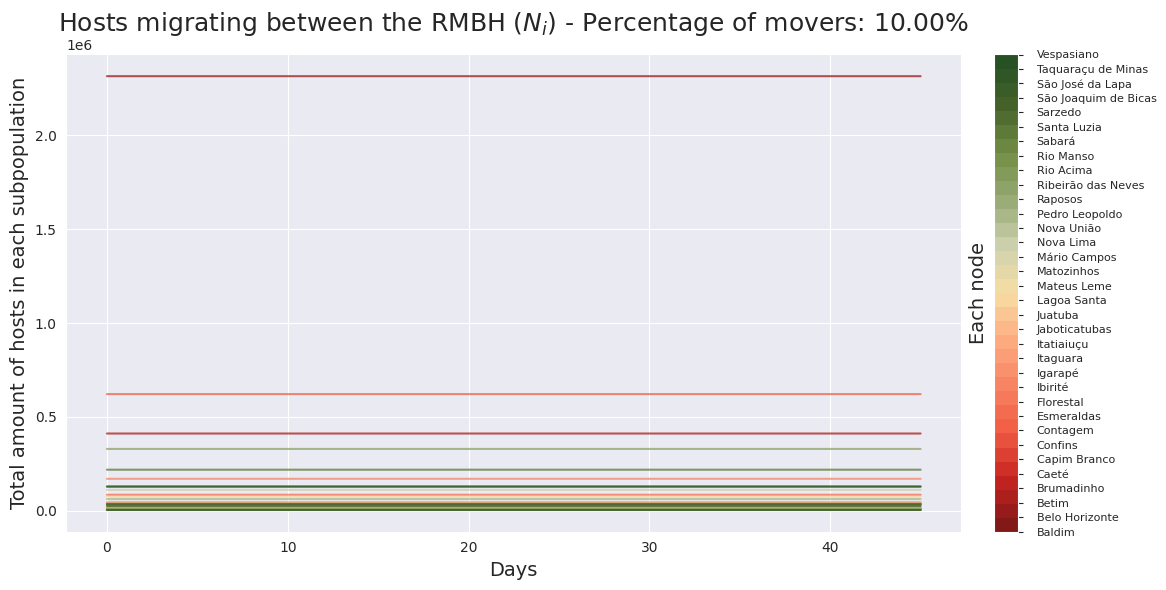

INTEGRATION STEPS:
[0.00100002 0.00100002 0.00100002 ... 0.00100002 0.00100002 0.00100002]


In [13]:
cmap = ['#831818FF', '#C62320FF', '#F05B43FF', '#F78462FF', '#FEAC81FF', '#F7DEA3FF', '#CED1AFFF', '#98AB76FF', '#748F46FF', '#47632AFF', '#275024FF']
cmap = LinearSegmentedColormap.from_list('paquin', cmap[:], N=np.shape(inflow)[1])

t_span = (0, 45)  # Intervalo de tempo de 45 dias
#t_span =(0, 5)

flux_model = FluxModel(N0, inflow, outflow)
solution = flux_model.solve(t_span, N0, num_points=45000)
#solution = flux_model.solve(t_span, N0, num_points=5000)

t = solution.t
N_t = solution.y

# Criação da figura e do eixo (axes)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

for i in range(np.shape(inflow)[1]):
    ax.plot(t, N_t[i], color=cmap(i), alpha=.75)

ax.set_xlabel('Days', fontsize=14)
ax.set_ylabel('Total amount of hosts in each subpopulation', fontsize=14)
ax.set_title(r'Hosts migrating between the RMBH ($N_{i}$)' + f' - Percentage of movers: {per_movers * 100:.2f}%', fontsize=18)

# Adicionando a barra de cores à direita
norm = mpl.colors.Normalize(vmin=1, vmax=np.shape(inflow)[1])
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ticks = np.arange(1, np.shape(inflow)[1] + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar = plt.colorbar(sm, orientation='vertical', ax=ax, ticks=ticks, pad=0.03)
cbar.set_label('Each node', fontsize=14)
cbar.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar azul
cbar.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

plt.tight_layout()
#plt.savefig(f'/content/drive/MyDrive/data_IC/BH_data/output/models_integration/RMBH_flux_model_{per_movers * 100:.2f}%_movers.pdf')
#plt.savefig(f'/content/drive/MyDrive/data_IC/BH_data/output/models_integration/rede_pequena_{"10%"}_movers.pdf')
plt.show()

# Verificando os passos de integração
print("INTEGRATION STEPS:")
print(np.diff(solution.t))

CURRENT TIME POINT:  0.0 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.00014134620217111948 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.00282692404342239 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.004240386065133585 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.01130769617368956 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.012564106859655064 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.014134620217111949 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.014134620217111949 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.04240386065133585 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.05653848086844779 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.12721158195400753 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.1397756888136626 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.15548082238823144 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.15548082238823144 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.33136217016171954 - CALCULATED DAY:  0
CURRENT TIME POINT:  0.41930284404846363 - CALCULATED DAY:  0
CURRENT TIME POINT

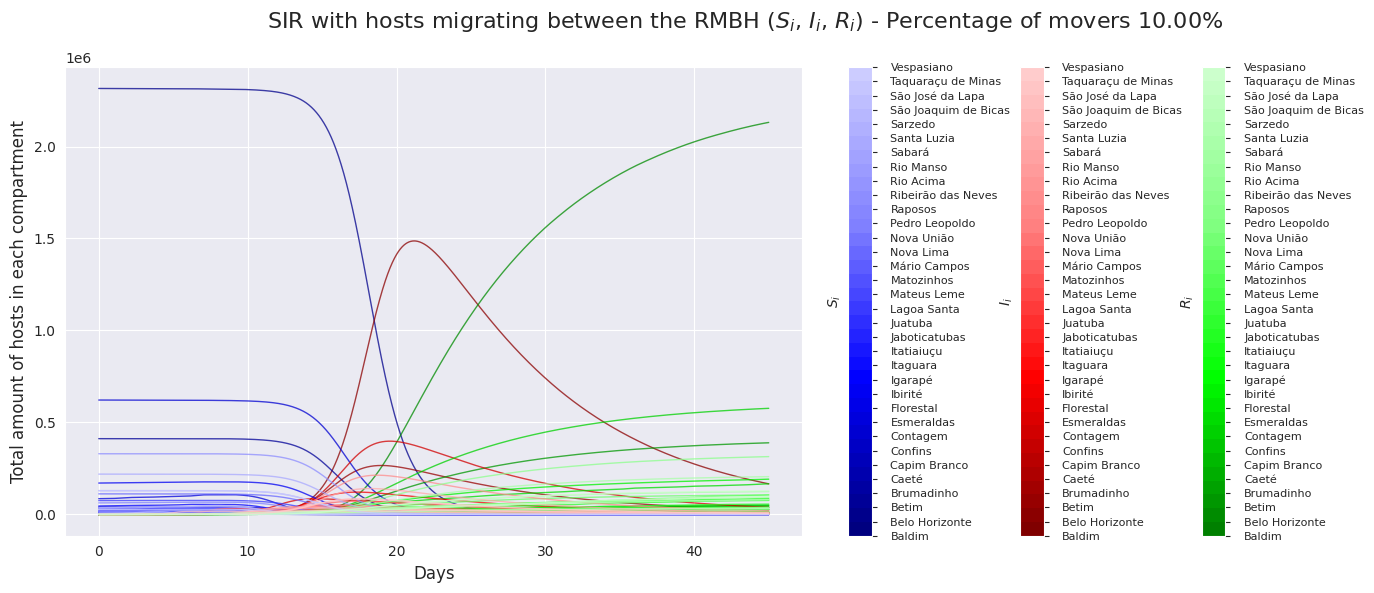

In [14]:
# Definindo os colormaps
blue_colors = [(0, 0, 0.5), (0, 0, 1), (0.5, 0.5, 1), (0.8, 0.8, 1)]  # azul escuro para azul claro
green_colors = [(0, 0.5, 0), (0, 1, 0), (0.5, 1, 0.5), (0.8, 1, 0.8)]  # verde escuro para verde claro
red_colors = [(0.5, 0, 0), (1, 0, 0), (1, 0.5, 0.5), (1, 0.8, 0.8)]  # vermelho escuro para vermelho claro

n_bins = np.shape(inflow)[1]  # número de bins para o colormap

blue_cmap = LinearSegmentedColormap.from_list('dark_to_light_blue', blue_colors, N=n_bins)
green_cmap = LinearSegmentedColormap.from_list('dark_to_light_green', green_colors, N=n_bins)
red_cmap = LinearSegmentedColormap.from_list('dark_to_light_red', red_colors, N=n_bins)

S0 = N0 - 1
#S0 = np.array(data) - 1
I0 = np.array([1] * np.shape(inflow)[1])
R0 = np.array([0] * np.shape(inflow)[1])
#S0 = np.array([499] * np.shape(inflow)[1])  # Vetor inicial de suscetíveis em cada nó
#I0 = np.array([1] * np.shape(inflow)[1])  # Vetor inicial de infectados em cada nó
#R0 = np.array([0] * np.shape(inflow)[1])  # Vetor inicial de recuperados em cada nó
#beta = np.array([0.3] * np.shape(inflow)[1])  # Taxa de transmissão em cada nó
#beta = np.random.uniform(0, 0.95, len(names))
beta = np.array([0.9] * len(names))
#beta = np.random.uniform(0, 0.95, len(data))
gamma = 0.1  # Taxa de recuperação (constante para todos os nós)

sir_flux_model = SIRFluxModel(S0, I0, R0, inflow, outflow, beta, gamma)
t_span = (0, 45)  # Intervalo de tempo de 45 dias
#t_span = (0, 5)

#solution = sir_flux_model.solve(t_span, num_points=50000)
solution = sir_flux_model.solve(t_span, num_points=5000)

t = solution.t
S_t, I_t, R_t = np.split(solution.y, 3)

fig, ax = plt.subplots(figsize=(15, 6))  # Reduzindo o tamanho da figura

for i in range(np.shape(inflow)[1]):
    ax.plot(t, S_t[i], color=blue_cmap(i), lw=1, alpha=0.75)
    ax.plot(t, I_t[i], color=red_cmap(i), lw=1, alpha=0.75)
    ax.plot(t, R_t[i], color=green_cmap(i), lw=1, alpha=0.75)

# Adicionando barras de cores menores à direita com labels centralizados
norm = mpl.colors.Normalize(vmin=1, vmax=np.shape(inflow)[1])

sm_green = ScalarMappable(cmap=green_cmap, norm=norm)
sm_green.set_array([])
ticks_green = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_green = plt.colorbar(sm_green, orientation='vertical', ax=ax, ticks=ticks_green, pad=0.01)
cbar_green.set_label(r'$R_{i}$', fontsize=10)
cbar_green.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_green.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_green.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar verde
cbar_green.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

sm_red = ScalarMappable(cmap=red_cmap, norm=norm)
sm_red.set_array([])
ticks_red = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_red = plt.colorbar(sm_red, orientation='vertical', ax=ax, ticks=ticks_red, pad=0.03)
cbar_red.set_label(r'$I_{i}$', fontsize=10)
cbar_red.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_red.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_red.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar vermelho
cbar_red.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

sm_blue = ScalarMappable(cmap=blue_cmap, norm=norm)
sm_blue.set_array([])
ticks_blue = np.arange(1, n_bins + 1, 1)  # Definindo os ticks de 1 a np.shape(inflow)[1]
cbar_blue = plt.colorbar(sm_blue, orientation='vertical', ax=ax, ticks=ticks_blue, pad=0.05)
cbar_blue.set_label(r'$S_{i}$', fontsize=10)
cbar_blue.ax.yaxis.set_label_position('left')  # Posiciona o label à direita
cbar_blue.ax.yaxis.set_ticks_position('right')  # Posiciona os ticks à direita
cbar_blue.ax.yaxis.set_tick_params(pad=10)  # Ajusta o espaço entre os ticks e o label

# Adicionando os nomes dos municípios como legendas no colorbar azul
cbar_blue.ax.set_yticklabels([names[i] for i in range(np.shape(inflow)[1])], fontsize=8)

ax.set_xlabel('Days', fontsize=12)
ax.set_ylabel('Total amount of hosts in each compartment', fontsize=12)
fig.suptitle(r'SIR with hosts migrating between the RMBH ($S_i$, $I_i$, $R_i$)' + f' - Percentage of movers {per_movers * 100:.2f}%', fontsize=16)

# Ajustando a posição da legenda
#ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.subplots_adjust(right=0.5)  # Ajustando o espaço à direita das barras de cores
plt.tight_layout()

# Salvando a figura como PDF otimizado
#plt.savefig(f'/content/drive/MyDrive/data_IC/BH_data/output/models_integration/RMBH_SIR_model_{per_movers * 100:.2f}%_movers.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()